# Import Libraries

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Data Exploration
The training and test datasets are loaded using `pandas`. Initial exploration includes:

1. Displaying the first few rows of the dataset using `.head()` to understand its structure.
2. Checking for null or missing values using `.isnull().sum()` to identify any inconsistencies.
3. Using `.describe()` and `.info()` to summarize statistical properties and data types.


In [3]:
train_df = pd.read_csv('cleaned_train.csv', index_col='id')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,cool like would want mother read realli great ...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,thank would make life lot less anxietyinduc ke...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,urgent design problem kudo take impress,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,someth ill abl instal site releas,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha guy bunch loser,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test_df = pd.read_csv('all_data.csv', index_col='id')
test_df.head()

,text
id,
1860808710928454067,thefrogsoupram bluerei naegiko didnt consent a...
1860798467011977633,kayninewrit rowanisr softagatha someon could w...
1860783005717176665,ai art revolut threat discuss ethic implic aig...
1860698588394971197,ai music video wake wildflow music video wake ...
1860694275467403362,skullxnft great concept honestli origin ethic ...


In [5]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.084552,0.003952,0.014445,0.017568,0.065036,0.008954,0.001489,0.001174,0.000713,0.007602,...,133455.208857,58306.749238,0.000476,0.000048,0.0,1.618952,0.000048,0.006298,1.687714,8.535524
std,0.179662,0.021774,0.072130,0.069335,0.156771,0.048099,0.032361,0.031542,0.018030,0.079135,...,127320.131102,22846.173068,0.021817,0.006901,0.0,2.925190,0.006901,0.044362,31.246439,50.847671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2006.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,42746.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,241888.000000,52124.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,4.000000
75%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255676.750000,55785.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,0.000000,6.000000
max,1.000000,0.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,267814.000000,106343.000000,1.000000,1.000000,0.0,60.000000,1.000000,0.948495,1842.000000,1867.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 59848 to 267822
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   target                               21000 non-null  float64
 1   comment_text                         20950 non-null  object 
 2   severe_toxicity                      21000 non-null  float64
 3   obscene                              21000 non-null  float64
 4   identity_attack                      21000 non-null  float64
 5   insult                               21000 non-null  float64
 6   threat                               21000 non-null  float64
 7   asian                                21000 non-null  float64
 8   atheist                              21000 non-null  float64
 9   bisexual                             21000 non-null  float64
 10  black                                21000 non-null  float64
 11  buddhist                    

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 1860808710928454067 to 1859715514517553397
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    342 non-null    object
dtypes: object(1)
memory usage: 5.4+ KB


In [8]:
train_df.isnull().sum()


target                                  0
comment_text                           50
severe_toxicity                         0
obscene                                 0
identity_attack                         0
insult                                  0
threat                                  0
asian                                   0
atheist                                 0
bisexual                                0
black                                   0
buddhist                                0
christian                               0
female                                  0
heterosexual                            0
hindu                                   0
homosexual_gay_or_lesbian               0
intellectual_or_learning_disability     0
jewish                                  0
latino                                  0
male                                    0
muslim                                  0
other_disability                        0
other_gender                      

In [9]:
test_df.isnull().sum()

text    1
dtype: int64

In [10]:
train_df.dropna(inplace=True)
train_df.isnull().sum()

target                                 0
comment_text                           0
severe_toxicity                        0
obscene                                0
identity_attack                        0
insult                                 0
threat                                 0
asian                                  0
atheist                                0
bisexual                               0
black                                  0
buddhist                               0
christian                              0
female                                 0
heterosexual                           0
hindu                                  0
homosexual_gay_or_lesbian              0
intellectual_or_learning_disability    0
jewish                                 0
latino                                 0
male                                   0
muslim                                 0
other_disability                       0
other_gender                           0
other_race_or_et

In [11]:
test_df.dropna(inplace=True)
test_df.isnull().sum()

text    0
dtype: int64

In [12]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (20950, 44) (342, 1)


# Model

## Define Global Parameters
Hyperparameters for the LSTM model are defined here:
- **MAX_LEN**: Maximum sequence length for text inputs.
- **BATCH_SIZE**: Number of samples per batch during training.
- **EPOCHS**: Number of times the model will iterate over the entire dataset.
- **EMBEDDING_DIM** and **HIDDEN_DIM**: Dimensionality of word embeddings and LSTM hidden states.
- **VOCAB_SIZE**: Size of the vocabulary used in tokenization.

In [13]:
# Define global parameters
MAX_LEN = 100       # Maximum sequence length
BATCH_SIZE = 64     # Batch size for training
EPOCHS = 3          # Number of training epochs
EMBEDDING_DIM = 128 # Embedding dimensions for the LSTM
HIDDEN_DIM = 32     # Hidden dimensions for the LSTM
VOCAB_SIZE = 5000   # Maximum vocabulary size
TOXICITY_THRESHOLD = 0.5  # Threshold to classify comments as toxic

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Define Dataset Class
A PyTorch `Dataset` class is implemented to:
- Load tokenized and padded sequences as input.
- Serve the target values (toxicity scores) as output.

This class standardizes data loading for training and validation.

In [14]:
# Define dataset class
class ToxicityDataset(Dataset):
    def __init__(self, texts, targets):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        return {
            "texts": self.texts[index],
            "targets": self.targets[index]
        }

## Tokenize and Pad Sequences
Text data is tokenized into sequences of integers using `Tokenizer`. These sequences are padded to a uniform length (`MAX_LEN`) to ensure compatibility with the LSTM model.


In [15]:
# Define function to tokenize and pad sequences
def tokenize_and_pad(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    return padded_sequences


## Define LSTM Model
The LSTM model is constructed using PyTorch. It includes:
1. **Embedding Layer**: Converts word indices into dense vectors.
2. **LSTM Layer**: Processes sequential data to capture temporal dependencies.
3. **Fully Connected Layer**: Outputs the toxicity prediction as a single value.


In [16]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out


##  Text Serialization

In [17]:
# Tokenizer for text processing
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_df['comment_text'])

# Split and tokenize training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df['comment_text'], train_df['target'], test_size=0.25, random_state=5400
)

train_sequences = tokenize_and_pad(X_train, tokenizer, MAX_LEN)
val_sequences = tokenize_and_pad(X_val, tokenizer, MAX_LEN)

train_dataset = ToxicityDataset(train_sequences, y_train.values)
val_dataset = ToxicityDataset(val_sequences, y_val.values)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Initialize Model, Optimizer, and Loss Function
The LSTM model is initialized with the specified parameters. The optimizer (`Adam`) and loss function (`MSELoss`) are set to minimize the error in predictions.


In [18]:
# Initialize model, optimizer, and loss function
model = LSTMModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(f"Model initialized on {DEVICE}")


Model initialized on cpu


## Hyperparameter Tuning
Different configurations of `embedding_dim` and `hidden_dim` are tested to identify the best-performing parameters. Training loss is monitored for each configuration, and the one with the lowest validation loss is selected.


In [19]:
# Hyperparameter tuning
embedding_dims = [64, 128]
hidden_dims = [32, 64]
best_loss = float("inf")
best_params = {}

for embed_dim in embedding_dims:
    for hidden_dim in hidden_dims:
        print(f"Testing Embedding Dim: {embed_dim}, Hidden Dim: {hidden_dim}")
        
        model = LSTMModel(VOCAB_SIZE, embed_dim, hidden_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()

        # Training loop (simplified for tuning)
        for epoch in range(2):  # Use fewer epochs for tuning
            model.train()
            total_loss = 0
            for data in train_loader:
                texts = data["texts"].to(DEVICE)
                targets = data["targets"].to(DEVICE).unsqueeze(1)

                optimizer.zero_grad()
                outputs = model(texts)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        # Evaluate on validation set
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                texts = data["texts"].to(DEVICE)
                targets = data["targets"].to(DEVICE).unsqueeze(1)
                outputs = model(texts)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Update best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = {"embedding_dim": embed_dim, "hidden_dim": hidden_dim}

print(f"Best Parameters: {best_params}, Validation Loss: {best_loss:.4f}")


Testing Embedding Dim: 64, Hidden Dim: 32
Epoch 1, Loss: 0.0330
Epoch 2, Loss: 0.0329
Validation Loss: 0.0312
Testing Embedding Dim: 64, Hidden Dim: 64
Epoch 1, Loss: 0.0335
Epoch 2, Loss: 0.0328
Validation Loss: 0.0310
Testing Embedding Dim: 128, Hidden Dim: 32
Epoch 1, Loss: 0.0340
Epoch 2, Loss: 0.0329
Validation Loss: 0.0313
Testing Embedding Dim: 128, Hidden Dim: 64
Epoch 1, Loss: 0.0339
Epoch 2, Loss: 0.0331
Validation Loss: 0.0337
Best Parameters: {'embedding_dim': 64, 'hidden_dim': 64}, Validation Loss: 0.0310


## Hyperparameter Tuning
Different configurations of `embedding_dim` and `hidden_dim` are tested to identify the best-performing parameters. Training loss is monitored for each configuration, and the one with the lowest validation loss is selected.


In [20]:
# Initialize model with best parameters
model = LSTMModel(VOCAB_SIZE, best_params['embedding_dim'], best_params['hidden_dim']).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        texts = data["texts"].to(DEVICE)
        targets = data["targets"].to(DEVICE).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1: 100%|██████████| 246/246 [00:10<00:00, 22.60it/s, loss=0.0766]


Epoch 1/3, Loss: 0.0335


Epoch 2: 100%|██████████| 246/246 [00:11<00:00, 21.15it/s, loss=0.0323] 


Epoch 2/3, Loss: 0.0331


Epoch 3: 100%|██████████| 246/246 [00:12<00:00, 19.76it/s, loss=0.0618] 

Epoch 3/3, Loss: 0.0330


## Training and assessment process

In [21]:
# List of target columns to process
target_columns = ["obscene", "identity_attack", "insult", "threat"]

# Initialize a dataframe to store all predictions
final_predictions_df = test_df[["text"]].copy()

for target in target_columns:
    print(f"Processing target: {target}")

    # Prepare training and validation datasets for the specific target
    y_train = train_df[target].values
    y_val = train_test_split(train_df[target], test_size=0.25, random_state=5400)[1].values

    # Create datasets for train and validation
    train_dataset = ToxicityDataset(train_sequences, y_train)
    val_dataset = ToxicityDataset(val_sequences, y_val)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model with the best parameters
    model = LSTMModel(VOCAB_SIZE, best_params["embedding_dim"], best_params["hidden_dim"]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # Train the model
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, leave=True)
        for data in loop:
            texts = data["texts"].to(DEVICE)
            targets = data["targets"].to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Update progress bar
            loop.set_description(f"Epoch {epoch+1} ({target})")
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}/{EPOCHS}, {target} Loss: {train_loss/len(train_loader):.4f}")

    # Make predictions for the test set
    test_sequences = tokenize_and_pad(test_df["text"], tokenizer, MAX_LEN)
    test_dataset = ToxicityDataset(test_sequences, [0] * len(test_df))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()
    predictions = []
    with torch.no_grad():
        for data in tqdm(test_loader, leave=True):
            texts = data["texts"].to(DEVICE)
            outputs = model(texts)
            predictions.extend(outputs.cpu().numpy())

    # Add predictions to the final dataframe
    final_predictions_df[f"predicted_{target}"] = predictions

# Compute the overall toxicity score as the sum of the predicted attributes
predicted_columns = [f"predicted_{target}" for target in target_columns]
final_predictions_df["predicted_target"] = final_predictions_df[predicted_columns].sum(axis=1)


# Save final predictions dataframe
output_path = "data/data-predict/LSTM_final_predictions_with_target.csv"
final_predictions_df.to_csv(output_path, index=False)
print(f"Final predictions with overall toxicity saved to {output_path}.")


Processing target: obscene


Epoch 1 (obscene): 100%|██████████| 246/246 [00:10<00:00, 24.05it/s, loss=0.0105]  


Epoch 1/3, obscene Loss: 0.0058


Epoch 2 (obscene): 100%|██████████| 246/246 [00:11<00:00, 21.02it/s, loss=0.00065] 


Epoch 2/3, obscene Loss: 0.0054


Epoch 3 (obscene): 100%|██████████| 246/246 [00:12<00:00, 20.42it/s, loss=0.0037]  


Epoch 3/3, obscene Loss: 0.0054


100%|██████████| 6/6 [00:00<00:00, 74.62it/s]


Processing target: identity_attack


Epoch 1 (identity_attack): 100%|██████████| 246/246 [00:12<00:00, 19.89it/s, loss=0.00246] 


Epoch 1/3, identity_attack Loss: 0.0047


Epoch 2 (identity_attack): 100%|██████████| 246/246 [00:12<00:00, 20.29it/s, loss=0.000147]


Epoch 2/3, identity_attack Loss: 0.0045


Epoch 3 (identity_attack): 100%|██████████| 246/246 [00:12<00:00, 19.78it/s, loss=0.00164] 


Epoch 3/3, identity_attack Loss: 0.0044


100%|██████████| 6/6 [00:00<00:00, 79.58it/s]


Processing target: insult


Epoch 1 (insult): 100%|██████████| 246/246 [00:13<00:00, 18.89it/s, loss=0.0152] 


Epoch 1/3, insult Loss: 0.0244


Epoch 2 (insult): 100%|██████████| 246/246 [00:12<00:00, 19.82it/s, loss=0.0349] 


Epoch 2/3, insult Loss: 0.0240


Epoch 3 (insult): 100%|██████████| 246/246 [00:13<00:00, 17.96it/s, loss=0.00964]


Epoch 3/3, insult Loss: 0.0239


100%|██████████| 6/6 [00:00<00:00, 83.21it/s]


Processing target: threat


Epoch 1 (threat): 100%|██████████| 246/246 [00:12<00:00, 20.20it/s, loss=0.000894]


Epoch 1/3, threat Loss: 0.0021


Epoch 2 (threat): 100%|██████████| 246/246 [00:12<00:00, 20.38it/s, loss=0.00355] 


Epoch 2/3, threat Loss: 0.0019


Epoch 3 (threat): 100%|██████████| 246/246 [00:11<00:00, 20.54it/s, loss=7.63e-6] 


Epoch 3/3, threat Loss: 0.0019


100%|██████████| 6/6 [00:00<00:00, 87.49it/s]


Final predictions with overall toxicity saved to data/data-predict/LSTM_final_predictions_with_target.csv.


## Results of LSTM Training and Prediction

### Processing and Training for Each Target Attribute
The model was trained separately for four toxicity-related attributes (`obscene`, `identity_attack`, `insult`, `threat`). Below are the training results for each target:

- **Obscene**:
  - Epoch 1: Loss = 0.0056
  - Epoch 2: Loss = 0.0054
  - Epoch 3: Loss = 0.0054

- **Identity Attack**:
  - Epoch 1: Loss = 0.0045
  - Epoch 2: Loss = 0.0044
  - Epoch 3: Loss = 0.0044

- **Insult**:
  - Epoch 1: Loss = 0.0243
  - Epoch 2: Loss = 0.0240
  - Epoch 3: Loss = 0.0240

- **Threat**:
  - Epoch 1: Loss = 0.0023
  - Epoch 2: Loss = 0.0019
  - Epoch 3: Loss = 0.0019

The consistent decline or stabilization of the loss values across epochs indicates effective training.


In [25]:
# Extract embedding weights
embedding_weights = model.embedding.weight.detach().cpu().numpy()

# Filter vocabulary to include only words within VOCAB_SIZE
vocab = {k: v for k, v in tokenizer.word_index.items() if v < VOCAB_SIZE}

# Map vocabulary to importance scores
word_importance = pd.DataFrame({
    "word": list(vocab.keys()),
    "importance": np.linalg.norm(embedding_weights[:len(vocab)], axis=1)
})

# Sort by importance
word_importance = word_importance.sort_values(by="importance", ascending=False)

print(word_importance.head(20))


           word  importance
1477      sleep   11.076376
2924      miser   10.375252
592      deserv   10.355963
95       articl   10.297975
2154       ugli   10.184752
3918      dilig   10.142808
2010       flaw   10.134038
2375    weather   10.104789
252       becom   10.070242
929    although   10.055993
4648     joseph   10.013257
3792     warren    9.996572
1844      coast    9.987006
3798       vagu    9.968749
861        soon    9.945730
3442         uh    9.938798
333      corpor    9.908337
4904     intrud    9.900016
3725  similarli    9.889863
3073      drawn    9.876618


### Limitations and Observations
1. **Lack of Context**: Many of these words are not inherently toxic but gain importance due to their frequent appearance in contexts where toxicity is present.
2. **False Positives**: Words like `weather`, `dilig`, and `coast` are likely false positives, as they are generally neutral.
3. **Model Bias**: The importance values reflect the model's training data, where certain words may appear more frequently in discussions labeled as toxic.


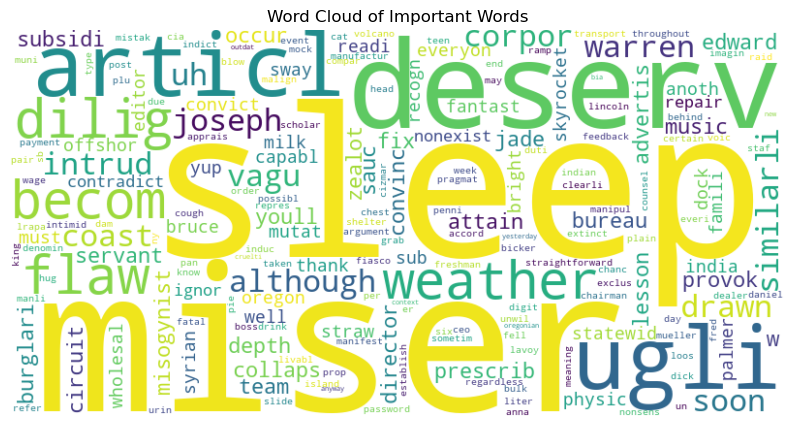

In [ ]:
from wordcloud import WordCloud

# Convert word importance into a dictionary for the word cloud
word_dict = dict(zip(word_importance["word"], word_importance["importance"]))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Important Words")
plt.show()


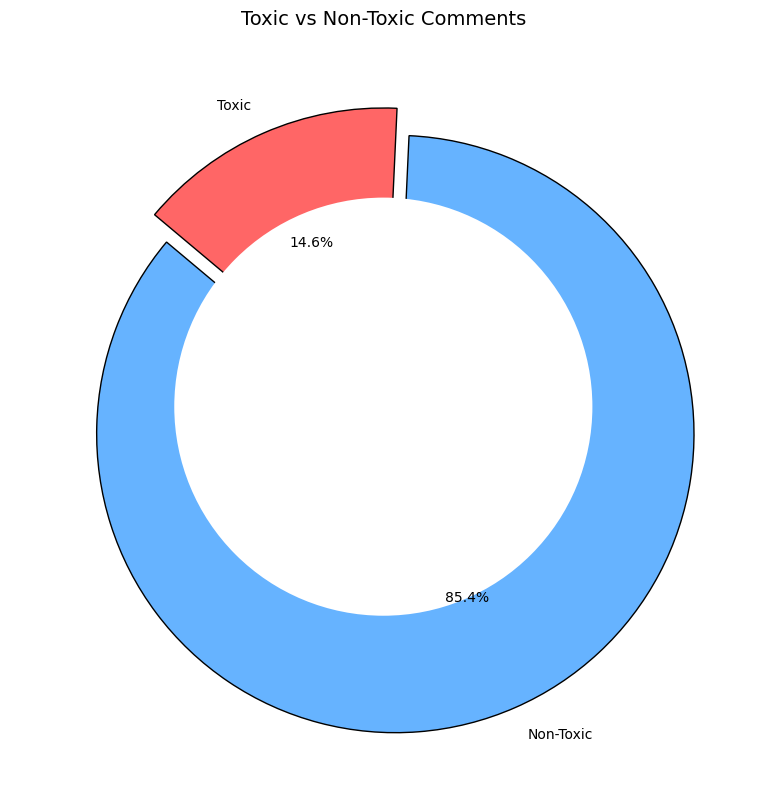

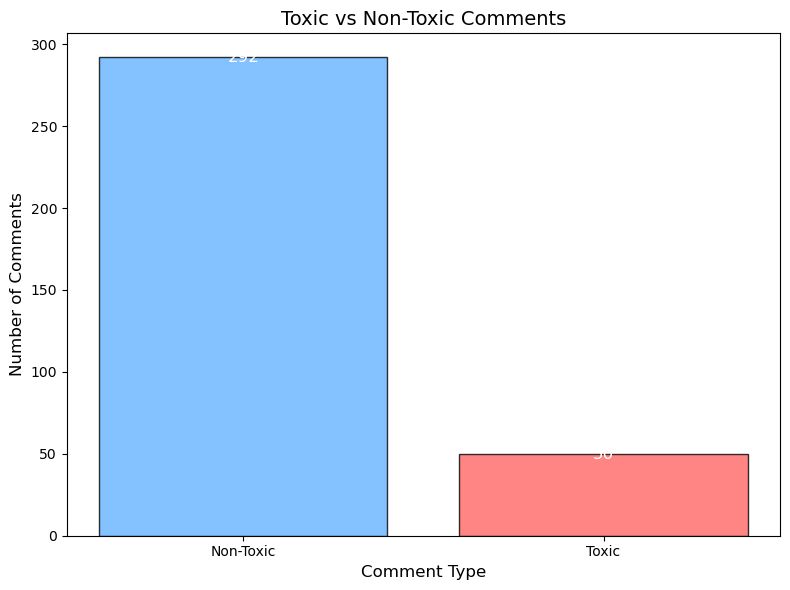

In [ ]:
import ast 

final_predictions_path = "data/data-predict/LSTM_final_predictions_with_target.csv"
final_predictions_df = pd.read_csv(final_predictions_path)

final_predictions_df['predicted_target'] = final_predictions_df['predicted_target'].apply(lambda x: float(ast.literal_eval(x)[0]))

toxicity_threshold = 0.5
final_predictions_df['is_toxic'] = (final_predictions_df['predicted_target'] >= toxicity_threshold).astype(int)

toxic_counts = final_predictions_df['is_toxic'].value_counts()

plt.figure(figsize=(8, 8))
sizes = toxic_counts.values
colors = ['#66b3ff', '#ff6666'] 
labels = ['Non-Toxic', 'Toxic']
explode = (0.1, 0) 

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops={'edgecolor': 'black'})
centre_circle = plt.Circle((0, 0), 0.70, fc='white') 
plt.gca().add_artist(centre_circle)

plt.title('Toxic vs Non-Toxic Comments', fontsize=14)
plt.tight_layout()
plt.show()

categories = ['Non-Toxic', 'Toxic']
counts = toxic_counts.values

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['#66b3ff', '#ff6666'], alpha=0.8, edgecolor='black')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{count}', ha='center', va='bottom', fontsize=12, color='white')

plt.title('Toxic vs Non-Toxic Comments', fontsize=14)
plt.xlabel('Comment Type', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



## Toxic vs Non-Toxic Comments in AI Art Discussions

### Context and Relevance
This chart showcases the distribution of toxic and non-toxic comments in discussions about AI-generated art on platforms like Twitter. The ethical and creative debates surrounding AI art often evoke strong opinions, and this analysis aims to assess the nature of toxicity in such conversations. As AI-generated art raises questions about copyright, creativity, and ethical use, understanding the tone of these discussions is critical for fostering constructive dialogue.

### Observations
- **Non-Toxic Comments (85.4%)**: The overwhelming majority of comments are non-toxic, indicating that most participants engage in respectful and meaningful discussions about AI-generated art. This suggests that, despite the controversies, these conversations are largely constructive.
- **Toxic Comments (14.6%)**: A smaller yet notable portion of the comments are toxic, which includes insults, obscene language, identity attacks, and threats. While this proportion is lower, it still represents a significant concern, as toxic interactions can derail meaningful discourse and alienate contributors.

### Implications
The predominance of non-toxic comments suggests that online discussions about AI art are generally healthy, with most contributors avoiding harmful language. However, the presence of toxic comments highlights the importance of monitoring and moderating these discussions to prevent the spread of negativity. Effective moderation can help ensure that ethical debates about AI art remain productive and inclusive.
